In [1]:
# XCEPTION
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [2]:
!ls /content/drive/MyDrive/Datasets/Datasets/archive


all_images		HAM10000_metadata.csv  hmnist_8_8_L.csv    train
HAM10000_images_part_1	hmnist_28_28_L.csv     hmnist_8_8_RGB.csv  val
HAM10000_images_part_2	hmnist_28_28_RGB.csv   test


In [4]:
import torch

print("CUDA:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0))

assert torch.cuda.is_available(), "GPU KAPALI!"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


CUDA: True
GPU: Tesla T4
Device: cuda


In [5]:
!pip install timm
import timm

import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import cv2
import seaborn as sns


# XCEPTION İÇİN ŞEMA
# Input Image (RGB, 224 × 224 × 3)
#         │
#         ▼
# Resize (224×224) + Normalize (ImageNet)
#         │
#         ▼
# ──────────────────────────────────
# ENTRY FLOW
# • Conv + BatchNorm + ReLU
# • Depthwise Separable Conv
# • Downsampling
# ──────────────────────────────────
#         │
#         ▼
# ──────────────────────────────────
# MIDDLE FLOW (8× tekrarlanan blok)
# • Depthwise Separable Conv
# • Residual Connections
# ──────────────────────────────────
#         │
#         ▼
# ══════════════════════════════════
# EXIT FLOW
# • Depthwise Separable Conv
# • High-level sınıfa özgü özellikler
# ══════════════════════════════════
#         │
#         ▼
# Global Average Pooling
#         │
#         ▼
# Fully Connected Layer (FC)
# (2048 → 7 sınıf)
#         │
#         ▼
# Softmax
#         │
#         ▼
# Output:
# (MEL, NV, BCC, AKIEC, BKL, DF, VASC)


In [6]:
BASE_DIR = "/content/drive/MyDrive/Datasets/Datasets/archive"
METADATA_PATH = f"{BASE_DIR}/HAM10000_metadata.csv"
metadata = pd.read_csv(METADATA_PATH)




classes = ['MEL','NV','BCC','AKIEC','BKL','DF','VASC']
label_map = {'mel':'MEL','nv':'NV','bcc':'BCC','akiec':'AKIEC','bkl':'BKL','df':'DF','vasc':'VASC'}

train_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
val_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])


class HAM10000Dataset(Dataset):
    def __init__(self, metadata, img_dir, label_map, transform=None):
        self.metadata = metadata.copy()
        self.img_dir = img_dir
        self.label_map = label_map
        self.transform = transform

        # Eksik dosyaları pas geçtik
        valid_indices = []
        possible_dirs = [
    f"{self.img_dir}/HAM10000_images_part_1",
    f"{self.img_dir}/HAM10000_images_part_2"
]




        for idx, row in self.metadata.iterrows():
            img_id = row['image_id']
            found = False
            for d in possible_dirs:
                for candidate in [img_id + ".jpg", img_id.lower() + ".jpg"]:
                    if os.path.exists(os.path.join(d, candidate)):
                        found = True
                        break
                if found: break
            if found: valid_indices.append(idx)

        self.metadata = self.metadata.loc[valid_indices].reset_index(drop=True)
        print(f"Geçerli örnek sayısı: {len(self.metadata)} (eksik görseller çıkarıldı)")

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]
        img_id = row['image_id']
        label = self.label_map[row['dx'].lower()]

        possible_dirs = [
    f"{self.img_dir}/HAM10000_images_part_1",
    f"{self.img_dir}/HAM10000_images_part_2"
]



        img_path = None
        for d in possible_dirs:
            for candidate in [img_id + ".jpg", img_id.lower() + ".jpg"]:
                p = os.path.join(d, candidate)
                if os.path.exists(p):
                    img_path = p
                    break
            if img_path is not None: break

        image = Image.open(img_path).convert("RGB")
        if self.transform: image = self.transform(image)
        label_idx = classes.index(label)
        return image, label_idx

full_ds = HAM10000Dataset(metadata, BASE_DIR, label_map, transform=train_tf)


train_ratio, val_ratio, test_ratio = 0.7, 0.15, 0.15
train_size = int(train_ratio * len(full_ds))  # %70
val_size = int(val_ratio * len(full_ds))      # %15
test_size = len(full_ds) - train_size - val_size # %15 oranında bölündü

train_ds, val_ds, test_ds = random_split(full_ds, [train_size,val_size,test_size], generator=torch.Generator().manual_seed(42))

train_ds.dataset.transform = train_tf
val_ds.dataset.transform = val_tf
test_ds.dataset.transform = val_tf

batch_size = 16 #gpu için 16 olarak ayarladım model resnet18'e göre daha ağır olduğundan.
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

Geçerli örnek sayısı: 10014 (eksik görseller çıkarıldı)


In [7]:
import os

print(os.listdir(BASE_DIR))
print(len(os.listdir(f"{BASE_DIR}/HAM10000_images_part_1")))
print(len(os.listdir(f"{BASE_DIR}/HAM10000_images_part_2")))


['all_images', 'HAM10000_images_part_1', 'HAM10000_images_part_2', 'HAM10000_metadata.csv', 'hmnist_28_28_L.csv', 'hmnist_28_28_RGB.csv', 'hmnist_8_8_L.csv', 'hmnist_8_8_RGB.csv', 'train', 'val', 'test']
9995
10030


In [8]:
print("Metadata toplam:", len(metadata))
print("Kullanılan örnek:", len(full_ds))


Metadata toplam: 10015
Kullanılan örnek: 10014


In [9]:

model = timm.create_model('xception', pretrained=True, num_classes=len(classes))
# Sadece son katman eğitilecek
for param in model.parameters():
    param.requires_grad = False
for param in model.get_classifier().parameters():
    param.requires_grad = True

model = model.to(device)

/usr/local/lib/python3.12/dist-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.get_classifier().parameters(), lr=1e-3)

In [11]:

def train_epoch(model, loader):
    model.train()
    total_loss = 0
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out,y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def eval_epoch(model, loader):
    model.eval()
    preds, labels = [], []
    total_loss = 0
    with torch.no_grad():
        for x,y in loader:
            x,y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out,y)
            total_loss += loss.item()
            preds.extend(torch.softmax(out,1).cpu().numpy())
            labels.extend(y.cpu().numpy())
    preds = np.array(preds)
    labels = np.array(labels)
    acc = (preds.argmax(1)==labels).mean()
    f1 = f1_score(labels, preds.argmax(1), average="macro")
    y_bin = label_binarize(labels, classes=range(len(classes)))
    roc = roc_auc_score(y_bin, preds, average="macro", multi_class="ovr")
    return total_loss/len(loader), acc, f1, roc


In [18]:
train_losses, val_losses, val_accs, f1s, rocs = [], [], [], [], []
num_epochs = 15

# sadece FC açık
for p in model.parameters():
    p.requires_grad = False

for name, p in model.named_parameters():
    if "fc" in name:
        p.requires_grad = True

optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-3
)

for epoch in range(num_epochs):

    # 10. epoch'ta Exit Flow açılıyor
    if epoch == 10:
        print("Fine-tuning başladı (Exit Flow + FC)")

        # Önce her şeyi dondurduk
        for p in model.parameters():
            p.requires_grad = False

        # Sonra Exit Flow + FC açtık
        for name, p in model.named_parameters():
            if "block11" in name or "block12" in name or "fc" in name:
                p.requires_grad = True

        optimizer = optim.Adam(
            filter(lambda p: p.requires_grad, model.parameters()),
            lr=1e-4
        )

    tr_loss = train_epoch(model, train_loader)
    val_loss, acc, f1, roc = eval_epoch(model, val_loader)

    train_losses.append(tr_loss)
    val_losses.append(val_loss)
    val_accs.append(acc)
    f1s.append(f1)
    rocs.append(roc)

    print(
        f"Epoch {epoch+1}/{num_epochs} | "
        f"Train Loss: {tr_loss:.4f} | "
        f"Val Loss: {val_loss:.4f} | "
        f"Val Acc: {acc:.4f} | "
        f"F1: {f1:.4f} | "
        f"ROC: {roc:.4f}"
    )


Epoch 1/15 | Train Loss: 0.6371 | Val Loss: 0.7390 | Val Acc: 0.7523 | F1: 0.4532 | ROC: 0.9002
Epoch 2/15 | Train Loss: 0.6100 | Val Loss: 0.7236 | Val Acc: 0.7530 | F1: 0.4155 | ROC: 0.8953
Epoch 3/15 | Train Loss: 0.6135 | Val Loss: 0.7046 | Val Acc: 0.7583 | F1: 0.4636 | ROC: 0.8999
Epoch 4/15 | Train Loss: 0.5883 | Val Loss: 0.7324 | Val Acc: 0.7477 | F1: 0.3722 | ROC: 0.8968
Epoch 5/15 | Train Loss: 0.6059 | Val Loss: 0.7155 | Val Acc: 0.7537 | F1: 0.5029 | ROC: 0.9028
Epoch 6/15 | Train Loss: 0.5965 | Val Loss: 0.7312 | Val Acc: 0.7437 | F1: 0.4781 | ROC: 0.8998
Epoch 7/15 | Train Loss: 0.5744 | Val Loss: 0.7454 | Val Acc: 0.7350 | F1: 0.3428 | ROC: 0.8960
Epoch 8/15 | Train Loss: 0.5822 | Val Loss: 0.7335 | Val Acc: 0.7570 | F1: 0.4498 | ROC: 0.8943
Epoch 9/15 | Train Loss: 0.5770 | Val Loss: 0.7419 | Val Acc: 0.7563 | F1: 0.4822 | ROC: 0.9031
Epoch 10/15 | Train Loss: 0.5646 | Val Loss: 0.7878 | Val Acc: 0.7290 | F1: 0.4689 | ROC: 0.8912
Fine-tuning başladı (Exit Flow + FC)
Ep

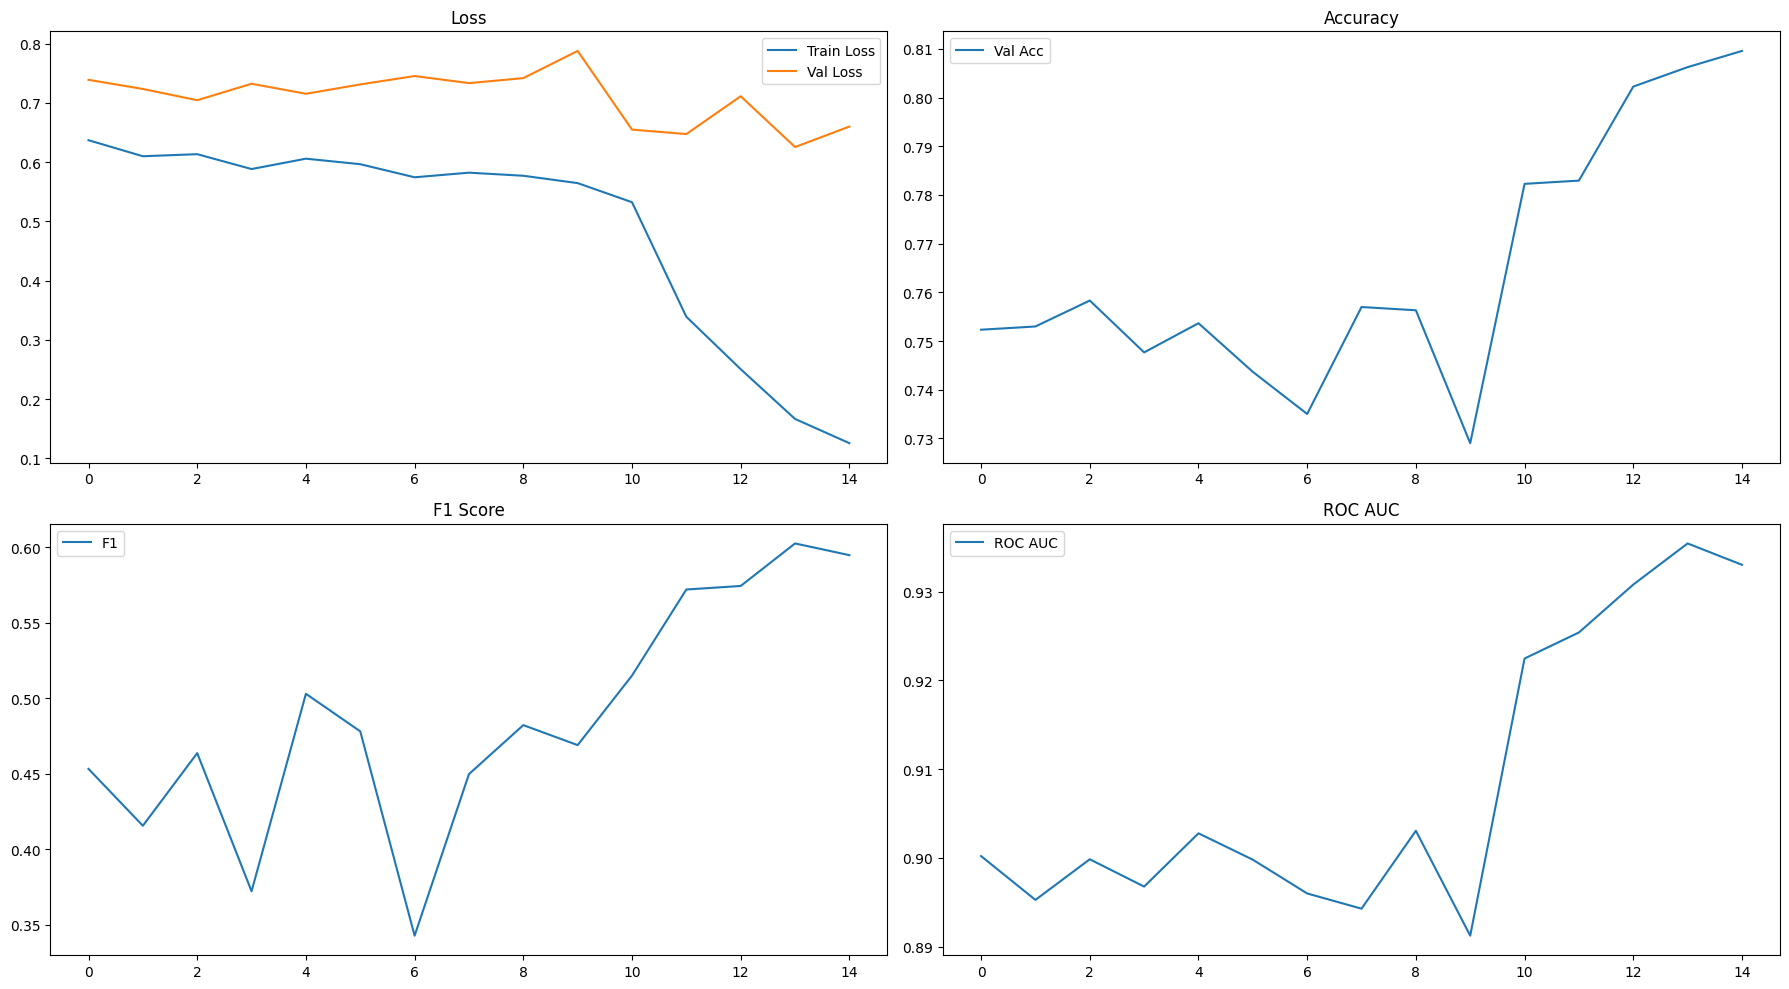

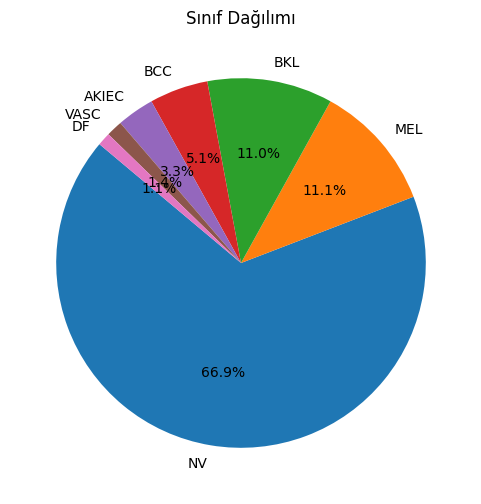

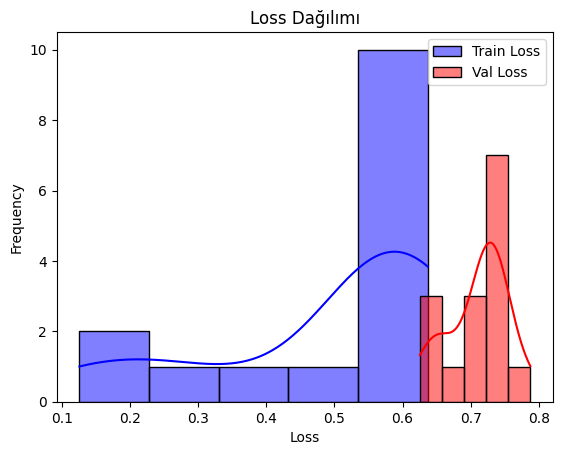

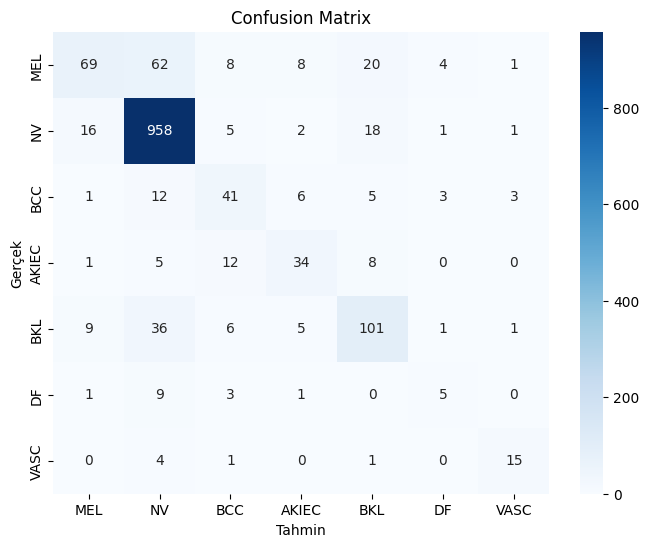

In [19]:
MODEL_NAME = "xception_7class"
BASE_RESULTS = "/content/drive/MyDrive/results"
RESULTS_DIR = f"{BASE_RESULTS}/{MODEL_NAME}"
os.makedirs(RESULTS_DIR, exist_ok=True)

plt.figure(figsize=(18,10))

plt.subplot(2,2,1)
plt.plot(train_losses,label="Train Loss")
plt.plot(val_losses,label="Val Loss")
plt.legend(); plt.title("Loss")

plt.subplot(2,2,2)
plt.plot(val_accs,label="Val Acc")
plt.legend(); plt.title("Accuracy")

plt.subplot(2,2,3)
plt.plot(f1s,label="F1")
plt.legend(); plt.title("F1 Score")

plt.subplot(2,2,4)
plt.plot(rocs,label="ROC AUC")
plt.legend(); plt.title("ROC AUC")

plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/training_metrics.png", dpi=300)
plt.show()


class_counts = metadata['dx'].map(lambda x: label_map[x.lower()]).value_counts()
plt.figure(figsize=(6,6))
plt.pie(class_counts, labels=class_counts.index, autopct="%1.1f%%", startangle=140)
plt.title("Sınıf Dağılımı")
plt.savefig(f"{RESULTS_DIR}/class_distribution_pie.png", dpi=300)
plt.show()


sns.histplot(train_losses, color="blue", label="Train Loss", kde=True)
sns.histplot(val_losses, color="red", label="Val Loss", kde=True)
plt.xlabel("Loss")
plt.ylabel("Frequency")
plt.title("Loss Dağılımı")
plt.legend()
plt.savefig(f"{RESULTS_DIR}/loss_histogram.png", dpi=300)
plt.show()


all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        all_preds.extend(torch.argmax(out,1).cpu().numpy())
        all_labels.extend(y.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=classes, yticklabels=classes, cmap="Blues")
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.title("Confusion Matrix")
plt.savefig(f"{RESULTS_DIR}/confusion_matrix_heatmap.png", dpi=300)
plt.show()

In [20]:
class GradCAM:
    def __init__(self, model, layer):
        self.model = model
        self.gradients = None
        self.activations = None

        layer.register_forward_hook(self.forward_hook)
        layer.register_backward_hook(self.backward_hook)

    def forward_hook(self, m, i, o):
        self.activations = o

    def backward_hook(self, m, gi, go):
        self.gradients = go[0]

    def generate(self, x, cls):
        out = self.model(x)
        self.model.zero_grad()
        out[0,cls].backward()

        weights = self.gradients.mean(dim=[2,3], keepdim=True)
        cam = (weights * self.activations).sum(dim=1)
        cam = torch.relu(cam)
        cam = cam / cam.max()
        return cam


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


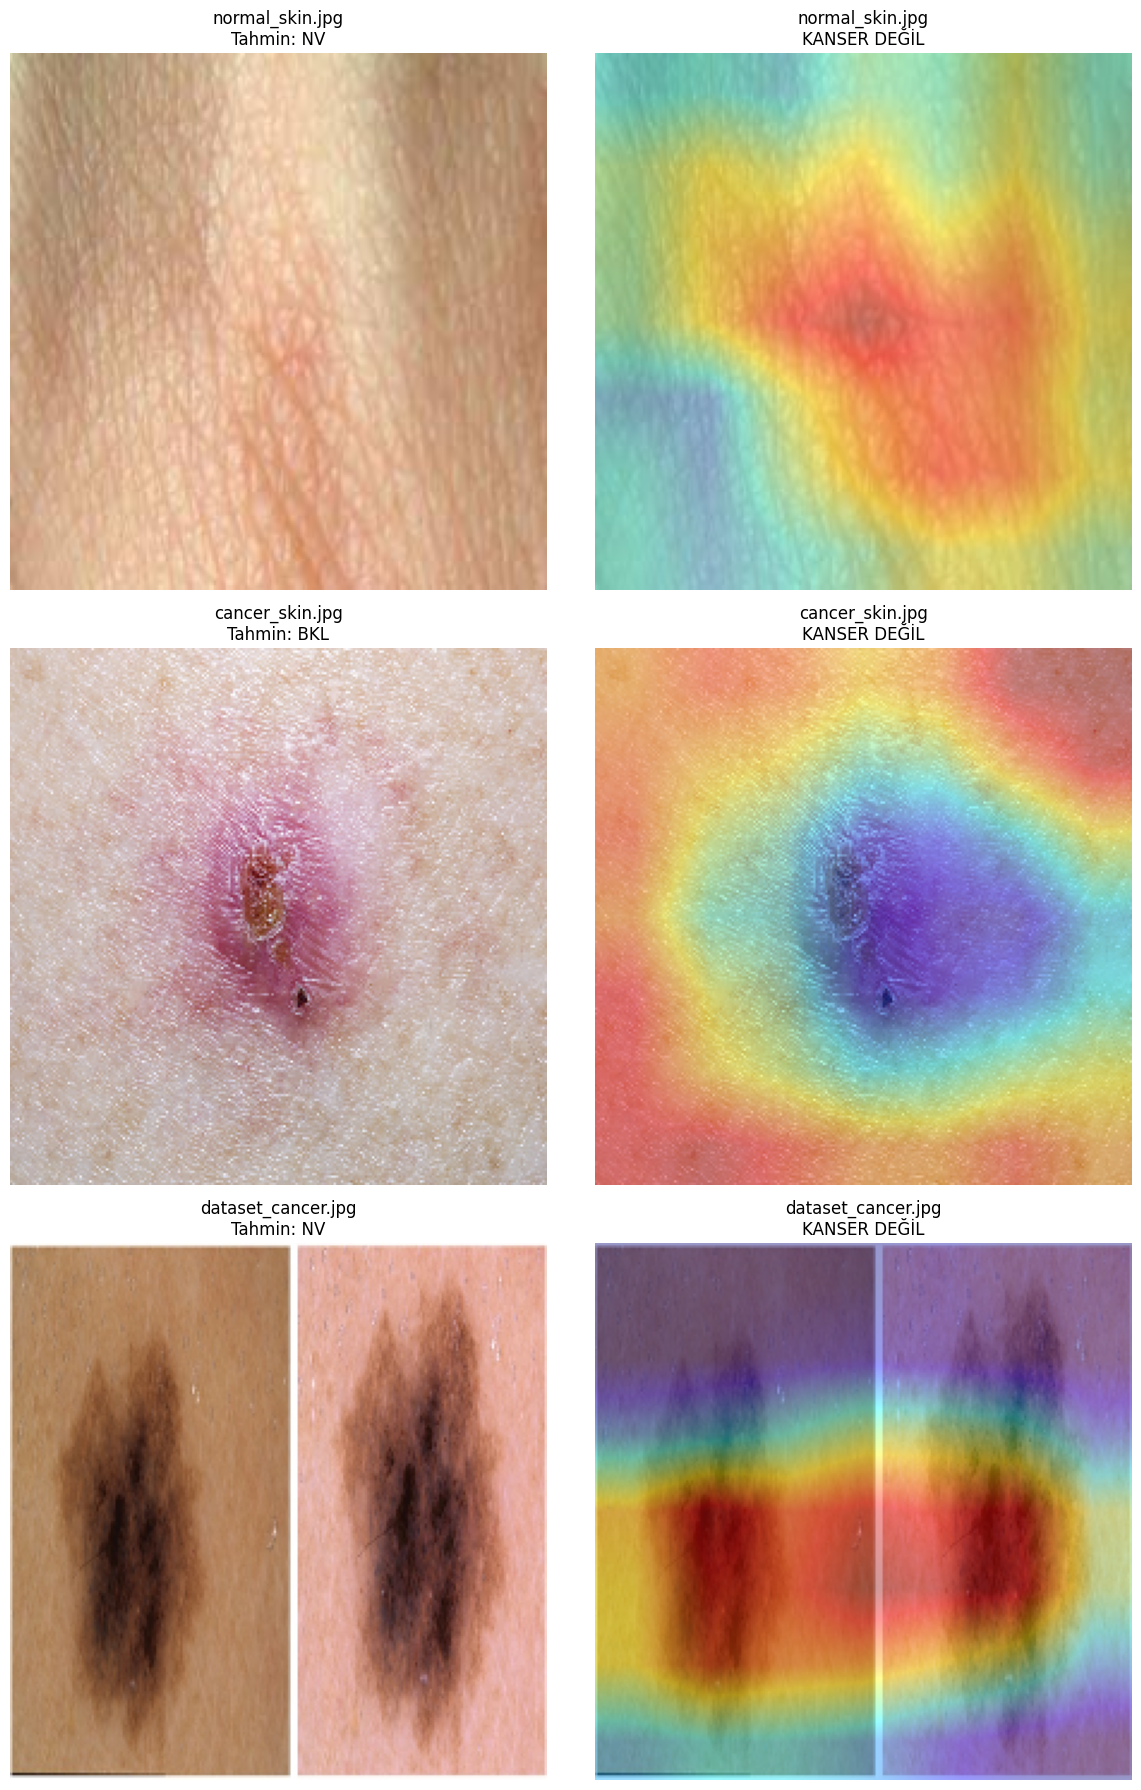

In [21]:


TEST_IMAGE_DIR = "/content/drive/MyDrive/test_gorselleri"
class_names = classes

def predict_image(img_path):
    model.eval()
    img = Image.open(img_path).convert("RGB")
    x = val_tf(img).unsqueeze(0).to(device)

    with torch.no_grad():
        out = model(x)
        cls = out.argmax(1).item()

    return x, cls


def analyze_test_images(image_dir):
    model.eval()
    cam = GradCAM(model, model.conv4)


    images = [f for f in os.listdir(image_dir) if f.endswith((".jpg", ".png"))]

    plt.figure(figsize=(12, len(images)*6))

    for i, img_name in enumerate(images):
        img_path = os.path.join(image_dir, img_name)

        # kanser mi değil mi
        x, cls = predict_image(img_path)
        label_name = class_names[cls]
        cancer_status = "KANSER" if label_name == "MEL" else "KANSER DEĞİL"

        # Grad-CAM
        heatmap = cam.generate(x, cls)[0].detach().cpu().numpy()
        heatmap = cv2.resize(heatmap, (224,224))
        heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

        GRADCAM_DIR = f"{RESULTS_DIR}/gradcam"
        os.makedirs(GRADCAM_DIR, exist_ok=True)


        # Orijinal görsel
        img = cv2.imread(img_path)
        img = cv2.resize(img, (224,224))

        overlay = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
        cv2.imwrite(f"{GRADCAM_DIR}/{img_name}",overlay)

        # Plot: Orijinal
        plt.subplot(len(images), 2, 2*i + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f"{img_name}\nTahmin: {label_name}")
        plt.axis("off")

        # Plot: Grad-CAM
        plt.subplot(len(images), 2, 2*i + 2)
        plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
        plt.title(f"{img_name}\n{cancer_status}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

analyze_test_images(TEST_IMAGE_DIR)


In [22]:
# kaydetme için

MODEL_NAME = "xception"

BASE_RESULTS = "/content/drive/MyDrive/results"
BASE_MODELS  = "/content/drive/MyDrive/models"

RESULTS_DIR = f"{BASE_RESULTS}/{MODEL_NAME}"
GRADCAM_DIR = f"{RESULTS_DIR}/gradcam"
MODEL_PATH  = f"{BASE_MODELS}/{MODEL_NAME}_skin_7class.pth"

os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(GRADCAM_DIR, exist_ok=True)
os.makedirs(BASE_MODELS, exist_ok=True)

# Model
torch.save(model.state_dict(), MODEL_PATH)

# Grafik
plt.savefig(
    f"{RESULTS_DIR}/training_metrics.png",
    dpi=300,
    bbox_inches="tight"
)

# CSV
import pandas as pd
df = pd.DataFrame({
    "epoch": range(1, len(train_losses)+1),
    "train_loss": train_losses,
    "val_loss": val_losses,
    "val_acc": val_accs,
    "f1": f1s,
    "roc_auc": rocs
})
df.to_csv(f"{RESULTS_DIR}/metrics.csv", index=False)

print("TÜM ÇIKTILAR KAYDEDİLDİ")



TÜM ÇIKTILAR KAYDEDİLDİ


<Figure size 640x480 with 0 Axes>